In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import dicom
import pydicom as dicom 
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import open3d as o3d


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import pydicom as dicom  
import os
import numpy as np

def load_scan(path):
    
    files = os.listdir(path)
    print("Files in directory:", files)  # 检查是否正确加载文件
    
    slices = []
    for s in files:
        file_path = os.path.join(path, s)
        
        # 跳过目录或非文件
        if os.path.isdir(file_path):
            print(f"Skipping directory: {file_path}")
            continue

        try:
            ds = dicom.dcmread(file_path, force=True)  # 使用 pydicom 的 dcmread 并强制读取

            # 检查是否有 ImagePositionPatient 属性
            if hasattr(ds, 'ImagePositionPatient') and ds.pixel_array.shape == (512, 512):
                slices.append(ds)
                print(f"{file_path} is ImagePositionPatient, added.")
            else:
                print(f"{file_path} does not contain ImagePositionPatient, skipping.")
        except Exception as e:
            print(f"Failed to read {file_path}: {e}")
    
    if len(slices) > 1:
        # 按 ImagePositionPatient[2] 排序
        slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))

        # 计算切片厚度
        try:
            slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
        except:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

        for s in slices:
            s.SliceThickness = slice_thickness
            
    return slices



In [3]:
# path = '/home/qiwen/Documents/CT_Daten/Case RS/2023-08-24-001/IMAGES/'
path = '/home/qiwen/Documents/CT_Daten/Case WM/2023-08-24-002/IMAGES/'
# path = '/home/qiwen/Documents/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00011637202177653955184'
first_patient = load_scan(path)

Files in directory: ['IM00418', 'IM00816', 'IM00530', 'IM00446', 'IM00382', 'IM01131', 'IM01025', 'IM00978', 'IM00143', 'IM00362', 'IM00912', 'IM00149', 'IM00527', 'IM00562', 'IM01150', 'IM00212', 'IM01018', 'IM00495', 'IM00424', 'IM01109', 'IM00058', 'IM00364', 'IM00603', 'IM00291', 'IM00633', 'IM01228', 'IM00481', 'IM00372', 'IM00767', 'IM00357', 'IM00378', 'IM00476', 'IM00370', 'IM01171', 'IM00421', 'IM01124', 'IM00180', 'IM00830', 'IM00427', 'IM00055', 'IM01231', 'IM00248', 'IM00827', 'IM00316', 'IM00230', 'IM00465', 'IM01214', 'IM00559', 'IM00034', 'IM00242', 'IM00453', 'IM00898', 'IM00345', 'IM01081', 'IM00902', 'IM00428', 'IM00412', 'IM00988', 'IM00791', 'IM00897', 'IM00762', 'IM01050', 'IM01179', 'IM00056', 'IM00116', 'IM00407', 'IM00931', 'IM01039', 'IM00395', 'IM00413', 'IM01032', 'IM00206', 'IM00431', 'IM00622', 'IM00289', 'IM00441', 'IM00151', 'IM01125', 'IM01136', 'IM00471', 'IM00011', 'IM01200', 'IM00188', 'IM01165', 'IM00960', 'IM00995', 'IM01010', 'IM00392', 'IM00297', 

In [4]:
def get_pixels_hu(slices):
    if len(slices) == 0:
        raise ValueError("The slices list is empty.")
    
    # Check the shape of pixel arrays
    for i, s in enumerate(slices):
        print(f"Slice {i} pixel array shape: {s.pixel_array.shape}")

    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [5]:
first_patient_pixels = get_pixels_hu(first_patient)


Slice 0 pixel array shape: (512, 512)
Slice 1 pixel array shape: (512, 512)
Slice 2 pixel array shape: (512, 512)
Slice 3 pixel array shape: (512, 512)
Slice 4 pixel array shape: (512, 512)
Slice 5 pixel array shape: (512, 512)
Slice 6 pixel array shape: (512, 512)
Slice 7 pixel array shape: (512, 512)
Slice 8 pixel array shape: (512, 512)
Slice 9 pixel array shape: (512, 512)
Slice 10 pixel array shape: (512, 512)
Slice 11 pixel array shape: (512, 512)
Slice 12 pixel array shape: (512, 512)
Slice 13 pixel array shape: (512, 512)
Slice 14 pixel array shape: (512, 512)
Slice 15 pixel array shape: (512, 512)
Slice 16 pixel array shape: (512, 512)
Slice 17 pixel array shape: (512, 512)
Slice 18 pixel array shape: (512, 512)
Slice 19 pixel array shape: (512, 512)
Slice 20 pixel array shape: (512, 512)
Slice 21 pixel array shape: (512, 512)
Slice 22 pixel array shape: (512, 512)
Slice 23 pixel array shape: (512, 512)
Slice 24 pixel array shape: (512, 512)
Slice 25 pixel array shape: (512, 5

In [6]:
first_patient_pixels.shape

(1193, 512, 512)

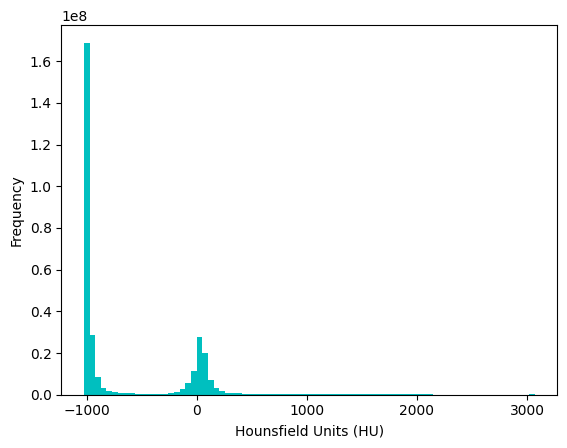

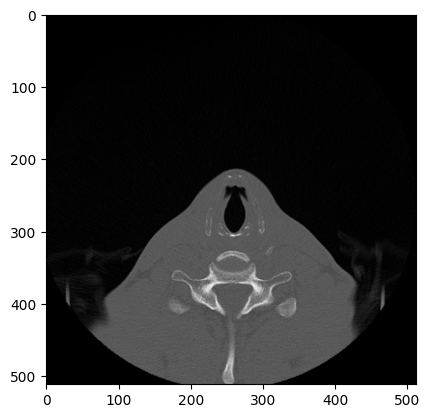

In [7]:
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[11], cmap=plt.cm.gray)
plt.show()

In [8]:
first_patient[2].PixelSpacing

[0.4492187202, 0.4492187202]

In [9]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    pixel_spacing = np.array(scan[0].PixelSpacing).astype(np.float32)

    spacing = np.array([scan[0].SliceThickness] + pixel_spacing.tolist(), dtype=np.float32)


    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [10]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

/tmp/ipykernel_20543/2009438759.py:14: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')


Shape before resampling	 (1193, 512, 512)
Shape after resampling	 (3560, 230, 230)


In [11]:
def normlize_plot_open3d(image, threshold=-300):
    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2, 1, 0)
    
    verts, faces, _, _ = measure.marching_cubes(p, threshold)  # Notice the extra underscore for normals

    min_bound = verts.min(axis=0)  # [min_x, min_y, min_z]
    max_bound = verts.max(axis=0)  # [max_x, max_y, max_z]

    scale = max_bound - min_bound  # [scale_x, scale_y, scale_z]
    verts_norm = verts / scale
    
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(verts_norm)
    
    file_name="CT_point_cloud.ply"
    
    o3d.io.write_point_cloud(file_name, point_cloud)
    print(f"Point cloud saved to {file_name}")
    
    o3d.visualization.draw_geometries([point_cloud])



In [13]:
normlize_plot_open3d(pix_resampled, 400)

Point cloud saved to CT_point_cloud.ply


In [29]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, threshold=-300):
    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2, 1, 0)
    # p = np.clip(p, a_min=threshold, a_max=500)

    # Get the vertices and faces
    verts, faces, _, _ = measure.marching_cubes(p, threshold)  # Notice the extra underscore for normals

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()



In [ ]:
plot_3d(pix_resampled, 400)

In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
